This python program aims to predict future prices of houses based on different variables found in the housing dataset.

Author: Gab Flores

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

Dataset contains real estate price in the Philippines as of 8/24/2022

In [16]:
# Load Data
housing_data = pd.read_csv('properties.csv')
ph_cities = pd.read_csv('ph_cities.csv')

In [17]:
# Data cleaning
housing_data = housing_data.rename(columns=lambda x: re.sub(r'\(.*\)', '', x).replace(' ', '_').replace('-', '_').lower())
housing_data = housing_data.drop('link', axis=1)
housing_data['city'] = housing_data['location'].str.split(',').str[1].str.strip().str.lower()
cols = list(housing_data.columns)
cols.remove('city')
cols.insert(2, 'city')
housing_data = housing_data.loc[:, cols]

# Merge
housing_data_2 = pd.merge(housing_data, ph_cities, on='city', how='left')
# Tag area type by urban or rural as another data point to explore. Urban =1, Rural=0
housing_data_2['area_type'] = housing_data_2['region'].apply(lambda x: '1' if pd.notna(x) else '0')
# Keep necessary columns
housing_data_2 = housing_data_2.drop(['longitude', 'latitude', 'province', 'description'], axis=1)

Condominiums Data Preprocessing

In [18]:
housing_data_condo = housing_data_2[(housing_data_2['category'] == "Condominium")]
housing_data_condo = housing_data_condo[['city', 'building_size', 'bedrooms', 'bathrooms', 'price']].reset_index(drop=True)

In [28]:
# Get the frequency of each city category
city_counts = housing_data_condo['city'].value_counts()

# Create a dictionary mapping each city category to its frequency rank
city_rank = {city: rank+1 for rank, city in enumerate(city_counts.index)}

# Create a new column in the dataframe with the frequency rank of each city
housing_data_condo['city_rank'] = housing_data_condo['city'].map(city_rank)

# Create a label encoder object
encoder = LabelEncoder()

# Fit the encoder to the city rank column
encoder.fit(housing_data_condo['city_rank'])

# Transform the city rank column using the encoder
housing_data_condo['city_encoded'] = encoder.transform(housing_data_condo['city_rank'])

# Drop the original city and city rank columns
housing_data_condo.drop('city_rank', axis=1, inplace=True)


In [20]:
# Clean Data
housing_data_condo = housing_data_condo.drop_duplicates().dropna()

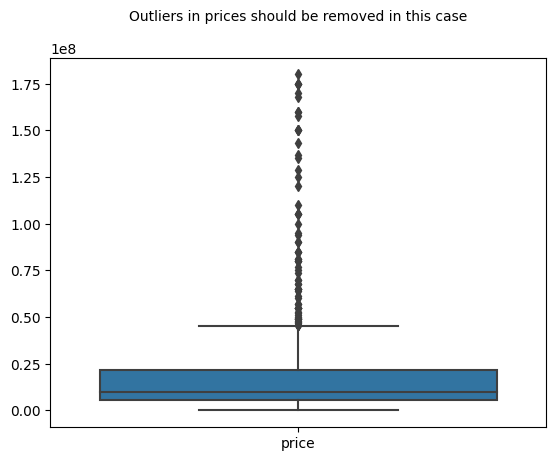

In [21]:
# Show the outliers
sns.boxplot(data=housing_data_condo[['price']])
plt.text(x=0.5, y=1.1, s="Outliers in prices should be removed in this case", fontsize=10, ha="center", transform=plt.gca().transAxes)
plt.show()

In [22]:
# Calculate the IQR
Q1 = housing_data_condo['price'].quantile(0.25)
Q3 = housing_data_condo['price'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
outliers = housing_data_condo[(housing_data_condo['price'] < lower_bound) | (housing_data_condo['price'] > upper_bound)]
housing_data_condo = housing_data_condo.drop(outliers.index)

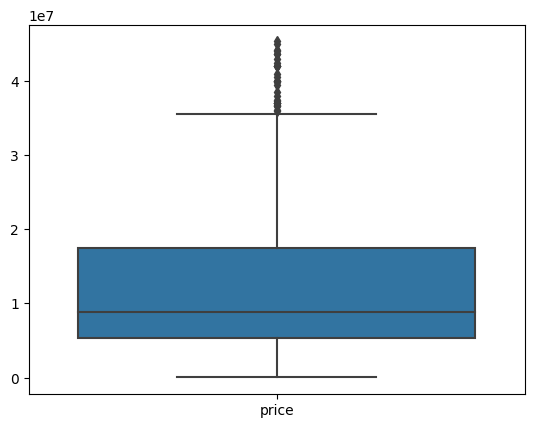

In [23]:
sns.boxplot(data=housing_data_condo[['price']])
plt.show()

Condo Price Prediction Model

In [24]:
# Split the dataset into training and testing
X = housing_data_condo[['building_size', 'bedrooms', 'bathrooms', 'city_encoded']]
y = housing_data_condo['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Ridge Regression model
alpha = 0.1
ridge_reg = Ridge(alpha=alpha)
ridge_reg.fit(X_train_scaled, y_train)

# Evaluate the model on the training set
y_train_pred = ridge_reg.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("Training set RMSE: ", train_rmse.round(2))

# Evaluate the model on the testing set
y_test_pred = ridge_reg.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Testing set RMSE: ", test_rmse.round(2))

Training set RMSE:  6061904.71
Testing set RMSE:  6340915.3


For model testing:

In [27]:
# Use the model to make predictions
new_data = np.array([[34, 1, 1, 1]]) # assume building size in sq meters, building size, #ofbedroom, #bathroom, city
new_data_scaled = scaler.transform(new_data)
new_price = ridge_reg.predict(new_data_scaled)
print("Predicted prices for new data: ", new_price.round(2))

Predicted prices for new data:  [9191945.8]


c:\Users\Gabriel Flores\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [37]:
city_table = housing_data_condo[['city', 'city_encoded']].drop_duplicates().sort_values('city_encoded', ascending=True).reset_index(drop=True)

In [38]:
city_table

,city,city_encoded
0,taguig,0
1,makati,1
2,pasig,2
3,mandaluyong,3
4,quezon city,4
5,manila,5
6,cebu,6
7,pasay,7
8,paranaque,8
9,lapu-lapu,9
